# Creating a Sentinel-2 Composite using Planetary Computer

## **Overview**

We will query for Sentinel-2 Level 2 imagery collected during 1 year over the city of Bangalore and create a median composite. The notebook shows how to use the data and compute from Planetary Computer to generate the results without any local computation.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your PC environment.

In [2]:
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import rasterio.features
import stackstac
import pystac_client
import planetary_computer
import geopandas as gpd
import xrspatial.multispectral as ms

from dask_gateway import GatewayCluster

In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [6]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

filename = 'bangalore.geojson'

download('https://github.com/spatialthoughts/python-tutorials/raw/main/data/' + filename)

### Create a Dask cluster

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [4]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=50, maximum=100)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.27f2f889bc5c46bd8ec25f115e1952a7/status


### Discover data

We will read the GeoJSON file containing the boundary of the city of Bangalore, India. We use the `total_bounds` attribute to extract the bounding box of the geometry.

In [7]:
file_path = os.path.join(data_folder, filename)
gdf = gpd.read_file(file_path)
bbox = gdf.total_bounds

Let's query for all Sentinel-2 images collected in the year 2020 over our bounding box. Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [8]:
stac = pystac_client.Client.open(
    'https://planetarycomputer.microsoft.com/api/stac/v1',
    modifier=planetary_computer.sign_inplace,
)

search = stac.search(
    bbox=bbox,
    datetime='2020-01-01/2020-12-31',
    collections=['sentinel-2-l2a'],
    query={'eo:cloud_cover': {'lt': 25}},
)

items = search.item_collection()
print(len(items))

47


So 47 items match our search requirements, over space, time, and cloudiness. Those items will still have *some* clouds over portions of the scenes, though. To create our cloudless mosaic, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then reduce the time-series of images down to a single image.

In [9]:
data = (
    stackstac.stack(
        items,
        assets=['B04', 'B03', 'B02'],  # red, green, blue
        chunksize=4096,
        resolution=10,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename('band'))  # use common names
)
data

,Array,Chunk
Bytes,242.02 GiB,128.00 MiB
Shape,"(47, 3, 10980, 20982)","(1, 1, 4096, 4096)"
Count,5 Graph Layers,2538 Chunks
Type,float64,numpy.ndarray


Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [10]:
data = data.persist()

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are transient, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images. Use XArray's aggregation methods to compute the median value.

In [11]:
median = data.median(dim='time')

We assign a CRS and clip the composite to the geometry of the city.

In [17]:
median = median.rio.write_crs('EPSG:32643', inplace=True)

In [18]:
geometry = gdf.to_crs('EPSG:32643').geometry.values
median_clipped = median.rio.clip(geometry)

The median image is still a virtual image. Let's compute and generate the image. This will be computed in parallel on the cluster (make sure to open the Dask Dashboard using the link printed out above).

In [19]:
median_composite = median_clipped.compute()

To visualize the data, we'll use xarray-spatial's `true_color` method to convert to red/green/blue values.

In [35]:
image = ms.true_color(*median_composite)  # expects red, green, blue DataArrays

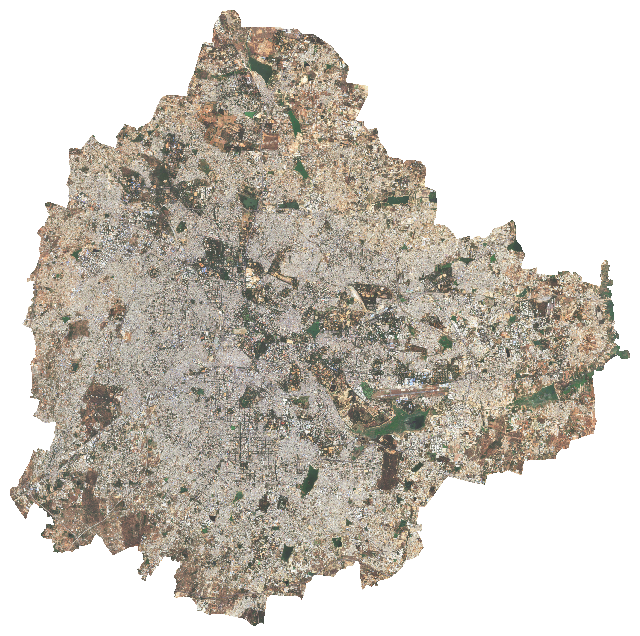

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8,8)
image.plot.imshow(ax=ax);
ax.set_axis_off()
plt.show()

Let's write the resulting image as a Cloud-Optimized GeoTIFF (COG) to the local disk using `rioxarray`.

In [21]:
output_file = 'bangalore_composite.tif'
output_path = os.path.join(output_folder, output_file)
median_composite.rio.to_raster(output_path, driver='COG')